# Tutorial for using the Fitness Landscape Sequence Design Simulator

* [Building oracles for landscapes](#section-one)
* [Building a model of the landscape](#section-two)
* [Exploring a landscape with a model](#section-three)
* [Evaluating an exploration algorithm](#section-four)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## 1. Building oracles for landscapes <a class="anchor" id="section-one"></a>

In [2]:
import flexs

problem = flexs.landscapes.rna.registry()['L14_RNA1+2']
problem

{'params': {'targets': ['GAACGAGGCACAUUCCGGCUCGCCCGGCCCAUGUGAGCAUGGGCCGGACCCCGUCCGCGCGGGGCCCCCGCGCGGACGGGGGCGAGCCGGAAUGUGCCUC',
   'GAGGCACAUUCCGGCUCGCCCCCGUCCGCGCGGGGGCCCCGCGCGGACGGGGUCCGGCCCGCGCGGGGCCCCCGCGCGGGAGCCGGAAUGUGCCUCGUUC'],
  'seq_length': 14},
 'starts': ['AUGGGCCGGACCCC',
  'GCCCCGCCGGAAUG',
  'UCUUGGGGACUUUU',
  'GGAUAACAAUUCAU',
  'CCCAUGCGCGAUCA']}

In [3]:
landscape = flexs.landscapes.RNABinding(**problem['params'])

You can now query the landscape for ground truth sequence fitnesses

In [4]:
landscape.get_fitness(["AUGCAUGUCAUCAU"])

array([0.16085976])

While we show this process on RNA landscapes there are other empirical landscapes that we have similar wrappers around. You can also make your own *custom* landscapes, but making RNA landcsapes with different targets, or a combination of targets (see the RNA_landscape_model_constructor for examples of how these can be made). 

In [96]:
rosetta_problem = flexs.landscapes.rosetta.registry()['3msi.pdb']
rosetta_problem

{'params': {'pdb_file': '/Users/stewartslocum/Downloads/FLSD-Sandbox/flexs/landscapes/data/rosetta/3msi.pdb'}}

In [100]:
protein_landscape = flexs.landscapes.RosettaFolding(**rosetta_problem['params'],
                                                    sigmoid_center=10,
                                                    sigmoid_norm_value=12)

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.mac.cxx11thread.serialization.python38.Release 2020.34+release.6dedbd4c240c738acaeac4698f33c74f6dd74076 2020-08-22T17:41:05] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [101]:
protein_wt = protein_landscape.wt_pose.sequence()
protein_wt

'MAQASVVANQLIPINTHLTLVMMRSEVVTPVGIPAEDIPRLVSMQVNRAVPLGTTLMPDMVKGYAA'

In [102]:
protein_landscape.get_fitness([protein_wt])

array([0.4904483], dtype=float32)

In [25]:
bert_gfp_landscape = flexs.landscapes.BertGFPBrightness()

In [26]:
gfp_sequence = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVT" \
               "TLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIE" \
               "LKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNT" \
               "PIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

bert_gfp_landscape.get_fitness([gfp_sequence])

array([3.57247734])

In [ ]:
seqs = set(s_utils.generate_random_mutant(gfp_sequence, 2 / len(gfp_sequence), s_utils.AAS) for _ in range(10000))

vals = bert_gfp_landscape.get_fitness(list(seqs))

In [105]:
tf_binding_problem = flexs.landscapes.tf_binding.registry()['VAX2_REF_R2']
tf_binding_problem

{'params': {'landscape_file': '/Users/stewartslocum/Downloads/FLSD-Sandbox/flexs/landscapes/data/tf_binding/VAX2_REF_R2_8mers.txt'}}

In [106]:
tf_binding_landscape = flexs.landscapes.TFBinding(**tf_binding_problem['params'])

In [107]:
tf_binding_landscape.get_fitness(["CGTATCAA"])

array([0.45653133])

## 2. Building a model of the landscape <a class="anchor" id="section-two"></a>

In reality, you don't have access to the ground truth landscape oracles except through costly experiments. Instead you can access an approximate version of it either by modeling the landscape through your current observations. In section 2.1 we use an abstract model to simulate the situation where you have a model with arbitrary noise. In section 2.2 we show some standard neural nets and use them as models of the landscape. It is easy to implement your own model. All they need to do is to implement `_fitness_function(sequence)` which gives you the model's estimate of a sequences fitness, and `update_model([sequence1, sequence2,...])` which will pay a cost to learn on the true labels of sequences.

### 2.1. Null model

The null model is the most simple model of the landscape. At each epoch, the model guesses the fitness of a variant by drawing a random sample from the exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = \mathbb{E}[f_\text{measured_sequences}]$. 

In [5]:
from flexs import baselines

null_model = baselines.models.NullModel()

We want to "measure" the true fitness of at least one sequence to start with (otherwise we can't have a model). We can do that by calling `measure_true_landscape` on the noisy model. This will charge you a "measurment cost", but in return tells you the true fitness of the sequence. When starting out or reusing the landscape, `reset` lets you zero the cost in the landscape, and if you pass it any sequences, it will measure those.  

In [6]:
# any start sequence can be used, we picked a few
# for you to use that are diverse in sequence and performance
wt = problem['starts'][3]
wt

'GGAUAACAAUUCAU'

let's ask it for the fitness of a random sequence (we will show more complex results later).

In [17]:
null_model.get_fitness([wt]), landscape.get_fitness([wt])

(array([0.13008573]), array([0.15601506]))

### 2.2 Abstract model 

This is an abstract model that "emulates" a real model of the landscape. It works by guessing the fitness of a new sequence as a combination of it's real fitness and fitness of the closest known neighbor. 

To build a noisy model, you need to have an oracle, and a `signal_strength` $\alpha \in [0,1]$. This parameter $\alpha$ determines how much your oracle signal is corrupted by noise:

$f_{model}= \alpha^d f_{oracle} + (1-\alpha^d)\epsilon$

here $d$ is the distance to the closest measured neighbor, and $\epsilon$ is a sample from an exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = f_\text{closest_neighbor}$ (for each queried sample, this is sampled once and then fixed for that batch). 

In [111]:
noisy_models = [baselines.models.NoisyAbstractModel(landscape, signal_strength=ss) for ss in [1, 0.9, 0.5, 0]]
for model in noisy_models:
    model.train([wt], landscape.get_fitness([wt]))

Let's measure the fitness of some samples through the model

In [7]:
import flexs.utils.sequence_utils as s_utils

val_x = np.array(list(set(s_utils.generate_random_mutant(wt, 0.2*(i%5), alphabet=s_utils.RNAA)
                  for i in range(1000))))
val_y = landscape.get_fitness(val_x)

noisy_preds = noisy_models[2].get_fitness(val_x[:5])
list(zip(val_x[:5], noisy_preds))

NameError: name 'noisy_models' is not defined

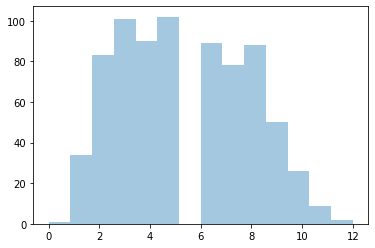

In [128]:
distances = [editdistance.eval(seq, wt) for seq in val_x]

sns.distplot(distances, kde=False)
plt.show()

In [129]:
import scipy.stats

def get_corr_per_distance(seqs, labels, preds):    
    corrs = []
    edit_distances = np.array([editdistance.eval(seq, wt) for seq in seqs])
    
    for dist in range(1, 11):
        seqs_at_dist = edit_distances == dist
        
        if seqs_at_dist.sum() > 50:
            corrs.append(
                scipy.stats.pearsonr(labels[seqs_at_dist], preds[seqs_at_dist])[0]**2
            )
        else:
            corrs.append(np.nan)
            
    return corrs

In [130]:
corrs_noisy_neighbors = [get_corr_per_distance(val_x, val_y, noisy_model.get_fitness(val_x))
                         for noisy_model in noisy_models]
corrs_null = get_corr_per_distance(val_x, val_y, null_model.get_fitness(val_x))

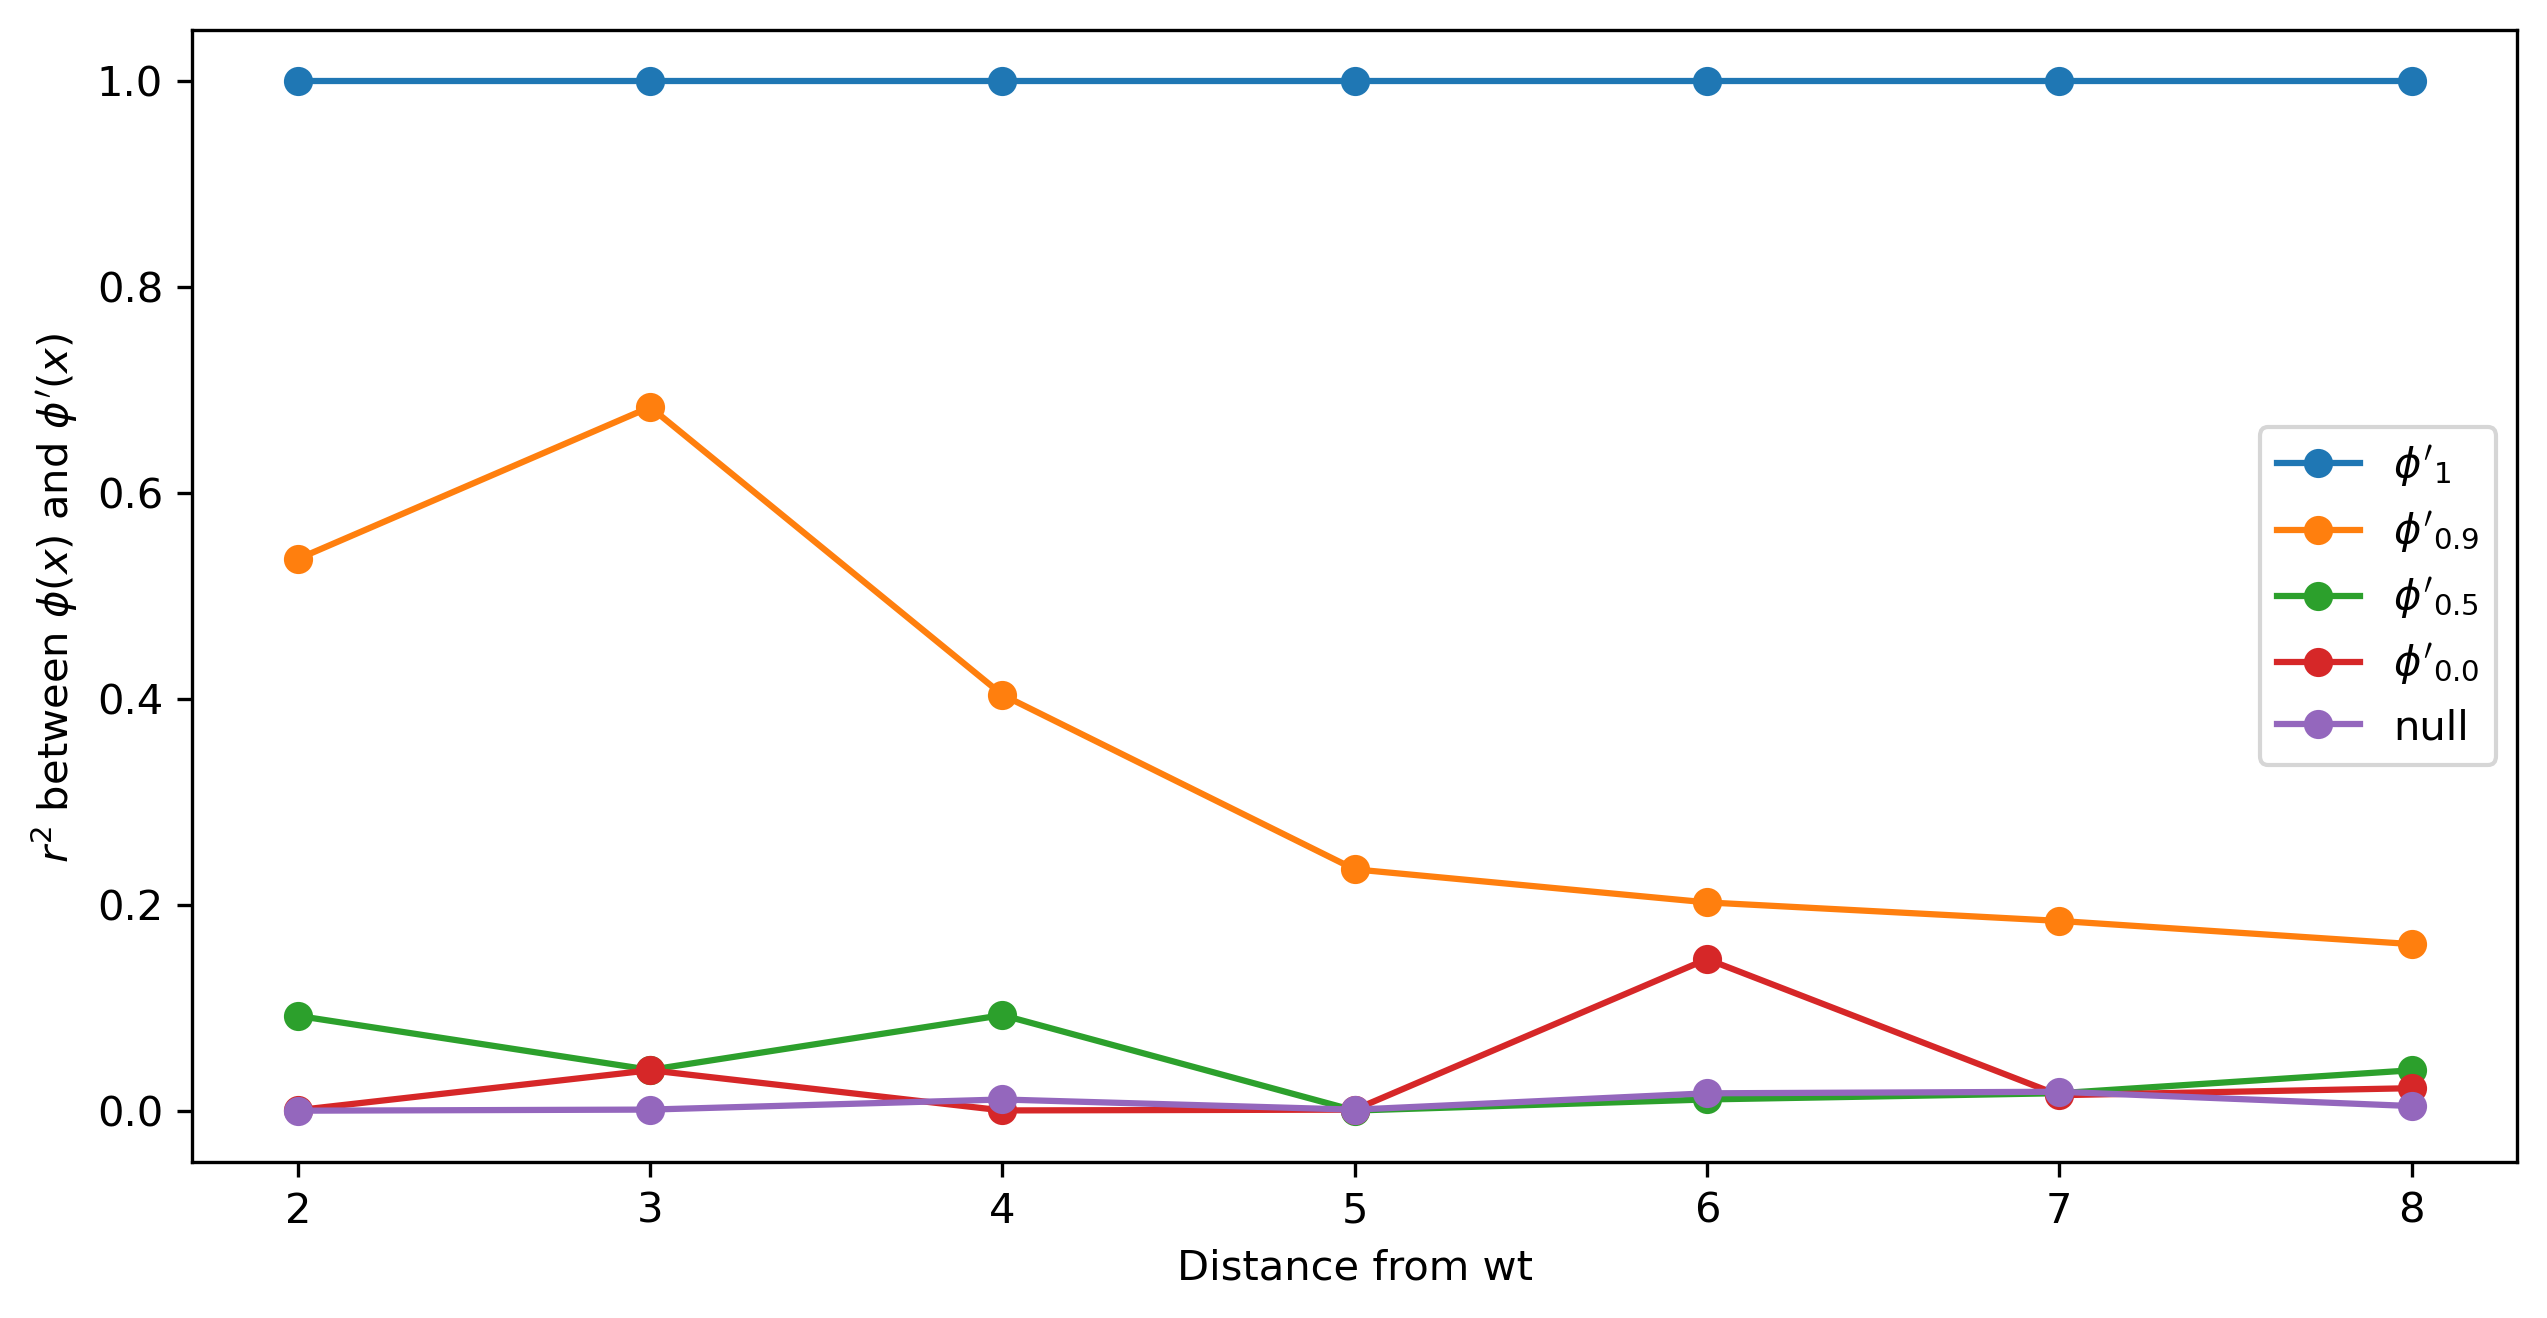

In [131]:
plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(1,11), corrs_noisy_neighbors[0], 'o-', label="$\phi'_{1}$")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")
plt.plot(range(1,11), corrs_noisy_neighbors[2], 'o-', label="$\phi'_{0.5}$")
plt.plot(range(1,11), corrs_noisy_neighbors[3], 'o-', label="$\phi'_{0.0}$")
plt.plot(range(1,11), corrs_null, 'o-', label="null")
plt.ylabel("$r^2$ between $\phi(x)$ and $\phi'(x)$ ")
plt.xlabel("Distance from wt")
plt.legend()
plt.show()

In [80]:
ensemble = flexs.Ensemble(noisy_models)

ensemble.train([wt], landscape.get_fitness([wt]))

In [81]:
ensemble.get_fitness([wt])

array([1.16892519])

In [82]:
ensemble.combine_with = lambda scores: scores
ensemble.get_fitness([wt])

array([[1.16892519, 1.16892519, 1.16892519, 1.16892519]])

### 2.3 Models of landscapes built from data

Similarly, we can approximate the landscape by training a model on it. Some basic architectures are provided for convenience. 

For real models, it's more sensible to train them on more than just the WT

In [132]:
train_x = np.array(list(set(s_utils.generate_random_mutant(wt, 0.2*(i%5), s_utils.RNAA)
                                 for i in range(0, 20000))))
train_y = landscape.get_fitness(train_x)
print (f'training data consisted of {len(train_x)} unique sequences')

training data consisted of 13306 unique sequences


In [133]:
linear_regression = baselines.models.LinearModel(alphabet=s_utils.RNAA, loss='regression')
linear_regression.train(train_x, train_y)

linear_regression_preds = linear_regression.get_fitness(val_x)
corrs_linear = get_corr_per_distance(val_x, val_y, linear_regression_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(linear_regression_preds, val_y)[0]**2}")

Overall correlation: 0.7500111221338405


In [134]:
random_forest = baselines.models.RandomForest(alphabet=s_utils.RNAA, loss='regression')
random_forest.train(train_x, train_y)

random_forest_preds = random_forest.get_fitness(val_x)
corrs_rf = get_corr_per_distance(val_x, val_y, random_forest_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(random_forest_preds, val_y)[0]**2}")

Overall correlation: 0.8306568323510528


In [135]:
sequence_length = len(train_x[0])

mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.RNAA, loss='MSE')
mlp.train(train_x, train_y)

mlp_preds = mlp.get_fitness(val_x)
corrs_mlp = get_corr_per_distance(val_x, val_y, mlp_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(mlp_preds, val_y)[0]**2}")

Overall correlation: 0.8672418018271167


In [136]:
cnn = baselines.models.CNN(sequence_length, alphabet=s_utils.RNAA, num_filters=32, hidden_size=100, loss='MSE')
cnn.train(train_x, train_y)

cnn_preds = cnn.get_fitness(val_x)
corrs_cnn = get_corr_per_distance(val_x, val_y, cnn_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_preds, val_y)[0]**2}")

Overall correlation: 0.9005973170837804


We can easily ensemble these models of the landscape as well. 

In [139]:
cnn_ensemble = flexs.Ensemble([
    baselines.models.CNN(sequence_length, alphabet=s_utils.RNAA, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])
cnn_ensemble.train(train_x, train_y)

cnn_ensemble_preds = cnn_ensemble.get_fitness(val_x)
corrs_cnn_ensemble = get_corr_per_distance(val_x, val_y, cnn_ensemble_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_ensemble_preds, val_y)[0]**2}")

Overall correlation: 0.9136223022024806


<AxesSubplot:>

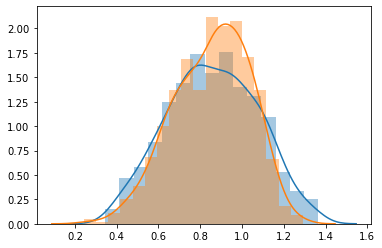

In [143]:
sns.distplot(val_y)
sns.distplot(linear_regression_preds)

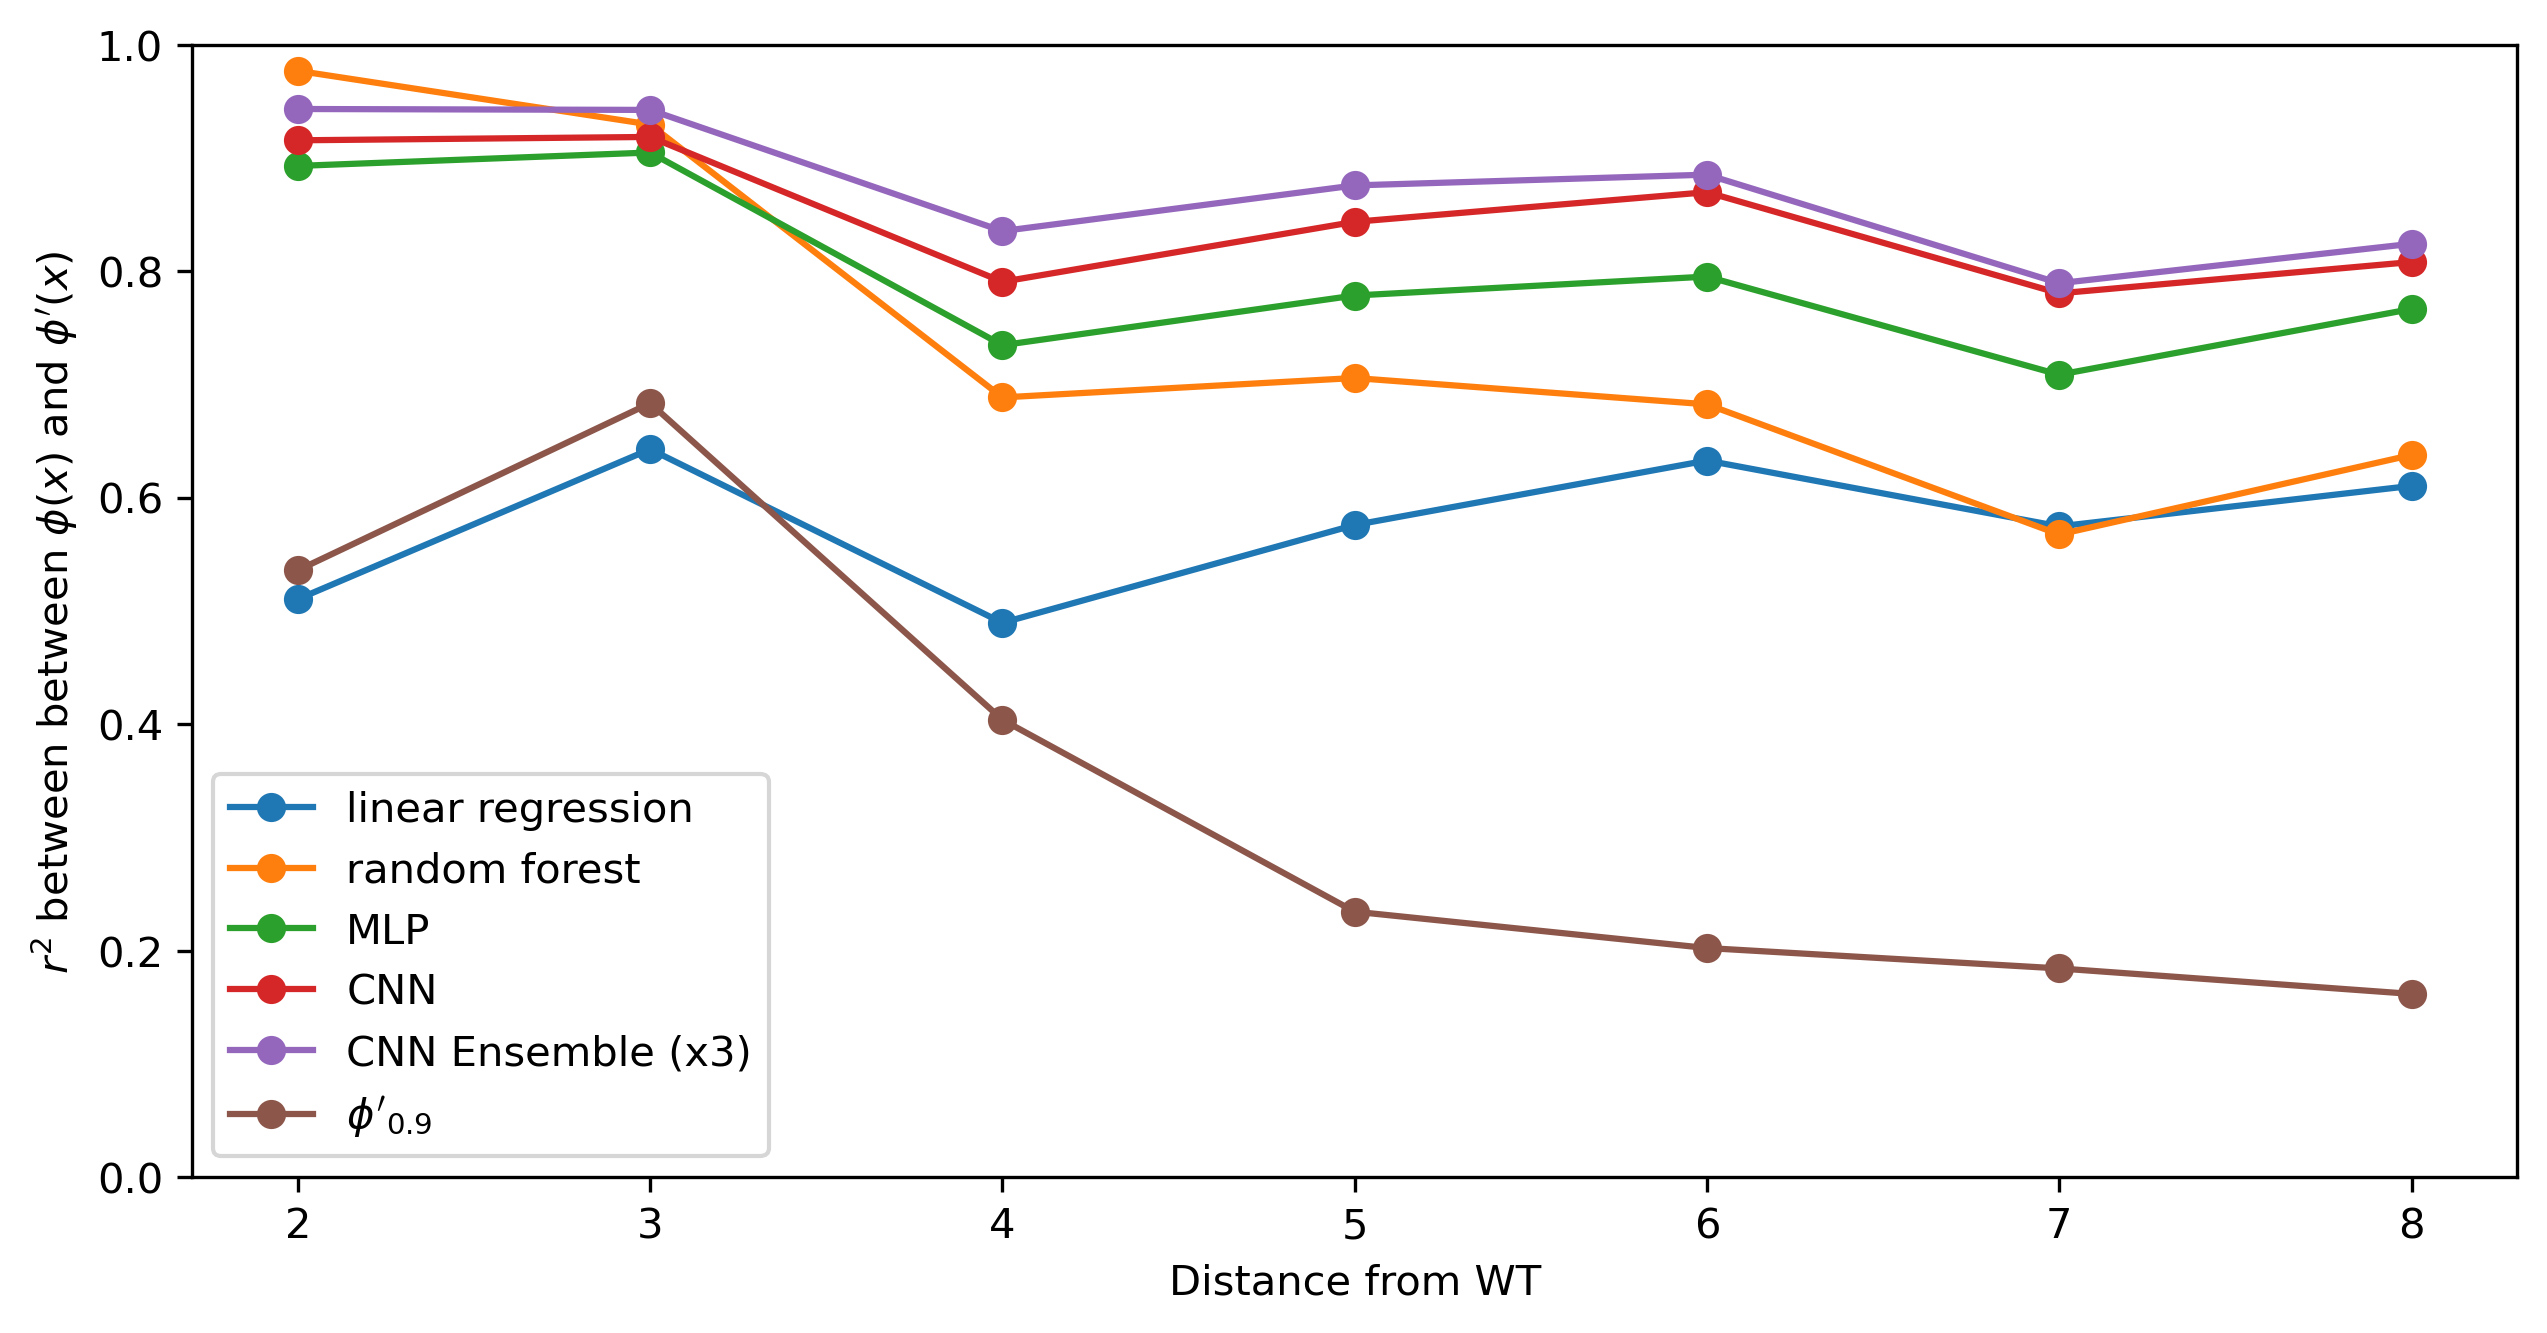

In [138]:
plt.figure(figsize=(10,5), dpi=300)

plt.plot(range(1,11), corrs_linear, 'o-', label="linear regression")
plt.plot(range(1,11), corrs_rf, 'o-', label="random forest")
plt.plot(range(1,11), corrs_mlp, 'o-', label="MLP")
plt.plot(range(1,11), corrs_cnn, 'o-', label="CNN")
plt.plot(range(1, 11), corrs_cnn_ensemble, 'o-', label="CNN Ensemble (x3)")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")

plt.ylabel("$r^2$ between between $\phi(x)$ and $\phi'(x)$")
plt.xlabel("Distance from WT")
plt.legend()
plt.ylim(0, 1)
plt.show()

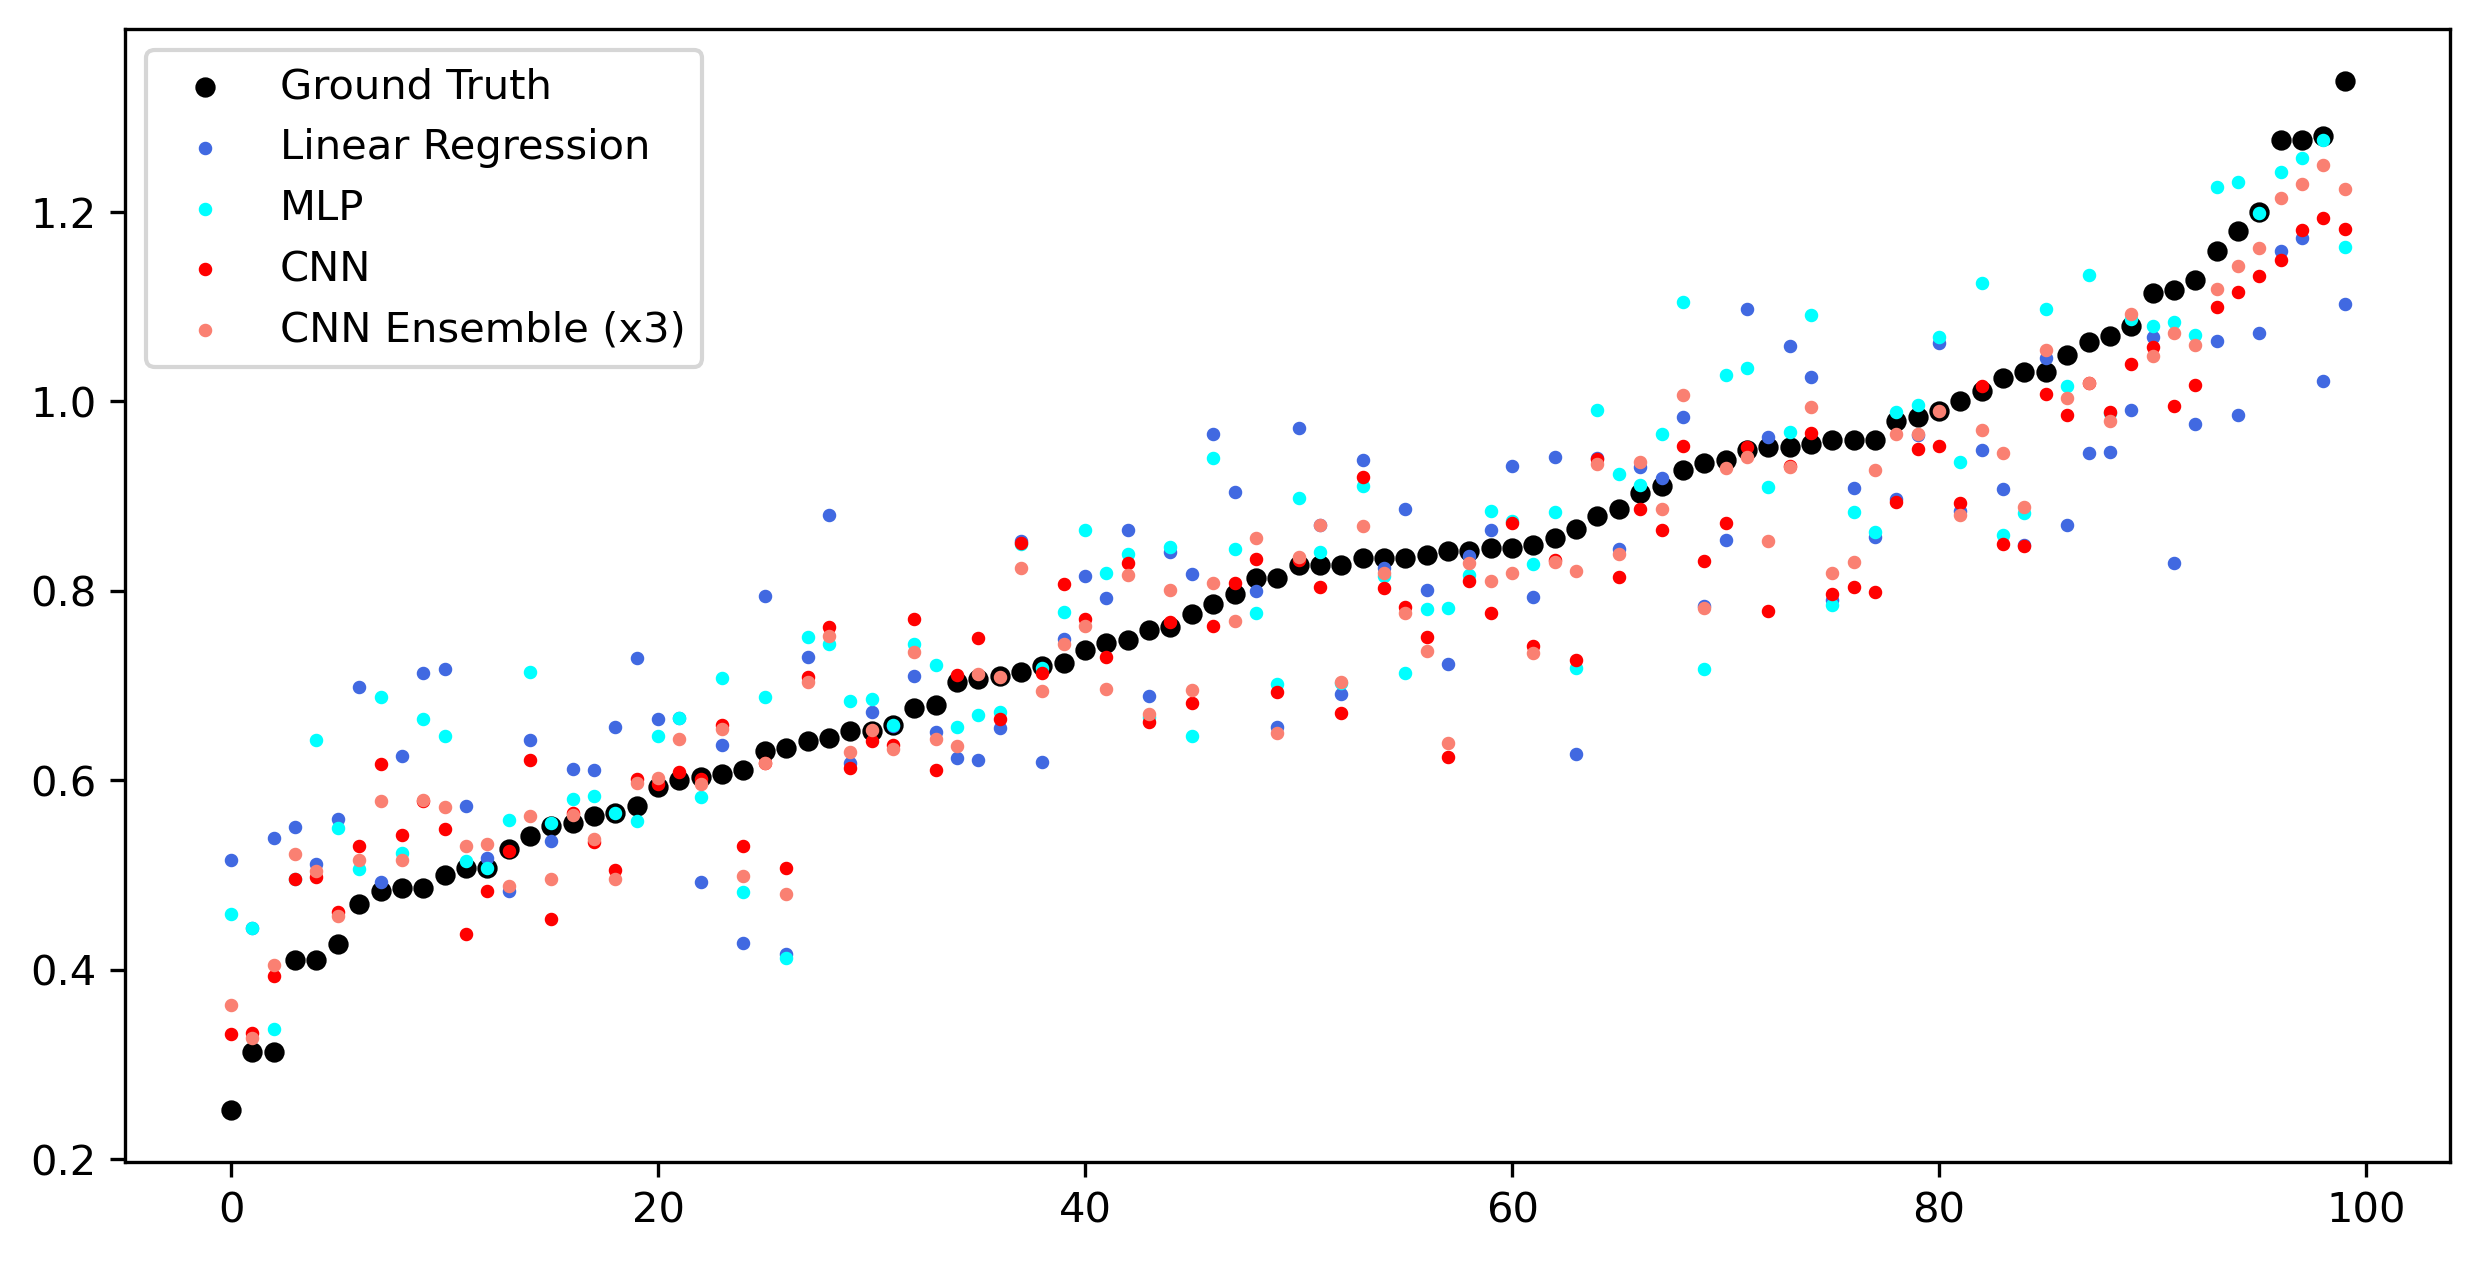

In [91]:
plt.figure(figsize=(10,5), dpi=300)

sort_order = np.argsort(val_y[:100])

plt.scatter(range(len(sort_order)), val_y[sort_order], c="k", s=15, label="Ground Truth")
plt.scatter(range(len(sort_order)), linear_regression_preds[sort_order], c="royalblue", s=5, label="Linear Regression")
plt.scatter(range(len(sort_order)), mlp_preds[sort_order], c="cyan", s=5, label="MLP")
plt.scatter(range(len(sort_order)), cnn_preds[sort_order], c="red", s=5, label="CNN")
plt.scatter(range(len(sort_order)), cnn_ensemble_preds[sort_order], c="salmon", s=5, label="CNN Ensemble (x3)")

plt.legend()
plt.show()

Now that we have models, we can use them with an exploration algorithm to search the landscape. 

## 3. Exploring the landscape with a model <a class="anchor" id="section-three"></a>

All exploration algorithms in this package inherit from `Base_explorer` which performs some house-keeping tasks. We recommend doing the same when you "bring your own" explorer. It's very easy to implement an explorer in this framework, all it needs to implement is a `propose_sequences` method, that suggest new sequences for which a "costly" measurment to the oracle is performed.  

In [64]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

random_explorer = baselines.explorers.Random(
    flexs.LandscapeAsModel(landscape),
    landscape,
    rounds=10,
    mu=2,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

- `sequences_batch_size` denotes the experimental batch size per round
- `model_queries_per_batch` is the number of computational queries to the model that is allowed per round. 
- `alphabet` is the alphabet that is permissive on the current landscape.

In [65]:
random_sequences, metadata = random_explorer.run()
random_sequences

round: 0, top: 0.15601505842016555
round: 1, top: 0.3626015762359993
round: 2, top: 0.46278593426895887
round: 3, top: 0.5318553677784292
round: 4, top: 0.5121397477097906
round: 5, top: 0.5703021076498478
round: 6, top: 0.4306088061175441
round: 7, top: 0.4484849748994477
round: 8, top: 0.5691103897014747
round: 9, top: 0.528098787538517
round: 10, top: 0.5502237836169588


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,GGAUAACAAUUCAU,NaN,0.156015,0,0,1
0,GGCUAACAAUUCAA,0.227546,0.227546,1,1001,101
1,CGAUAACAAUUGAU,0.061608,0.061608,1,1001,101
2,GGAUAUCAAGGCAU,0.245241,0.245241,1,1001,101
3,GGAUAAAACUUCAU,0.199332,0.199332,1,1001,101
...,...,...,...,...,...,...
95,UGGCAAGAACUCAU,0.277936,0.277936,10,10010,1001
96,GUAUAAAAGGUCAU,0.167052,0.167052,10,10010,1001
97,GGGACGCUCAUCAU,0.310061,0.310061,10,10010,1001
98,GUAUUUUAAGUCUC,0.163088,0.163088,10,10010,1001


Let's see what was printed:
- The number of **rounds** represents how many experiments was done
- The **cost** shows how many total calls to the oracle was made (experimental cost). Because training the model had an overhead, that is accounted in the total cost. 
- The **evals** shows how many total calls to the model was made (computational cost).
- **Top** simply lists the top fitness (cumulative) observed through the exploration

In [61]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

adalead_explorer = baselines.explorers.Adalead(
    flexs.LandscapeAsModel(landscape),
    landscape,
    rounds=10,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

In [62]:
adalead_sequences, metadata = adalead_explorer.run()
adalead_sequences

round: 0, top: 0.15601505842016555
round: 1, top: 0.6689061304524722
round: 2, top: 0.8263460817760622
round: 3, top: 0.941686343257131
round: 4, top: 0.941712267693145
round: 5, top: 0.8905189777640994
round: 6, top: 0.8931615544245786
round: 7, top: 0.8487819928741199
round: 8, top: 0.8680571517544637
round: 9, top: 0.8520981643052778
round: 10, top: 0.8455694517117716


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,GGAUAACAAUUCAU,NaN,0.156015,0,0,1
0,GCCCCGGGCUGGCU,0.668906,0.668906,1,1100,100
1,UUCGACGCGCGGGG,0.637247,0.637247,1,1100,100
2,GCCCCGGUCUGGCU,0.622169,0.622169,1,1100,100
3,AUCGACGCGCGGGG,0.618386,0.618386,1,1100,100
...,...,...,...,...,...,...
94,GCCACGCGCGGGCC,0.750385,0.750385,10,19000,991
95,GCCCCGUGCGCGCG,0.750204,0.750204,10,19000,991
96,GCCACCGCGCGGGG,0.750152,0.750152,10,19000,991
97,GCCCCGCGCGAGCU,0.749789,0.749789,10,19000,991


In [30]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

genetic_explorer = baselines.explorers.GeneticAlgorithm(
    cnn,
    landscape,
    
    population_size=20,
    parent_selection_strategy='wright-fisher', # roughly corresponds to who gets to mate
    beta=0.01,
    children_proportion=0.25,

    rounds=5,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

In [31]:
genetic_algo_sequences, metadata = genetic_explorer.run()
genetic_algo_sequences

round: 0, top: 0.15601505842016555
round: 1, top: 0.44172313923628487
round: 2, top: 0.6067280903872916
round: 3, top: 0.7194257752078812
round: 4, top: 0.8427973707494265
round: 5, top: 0.9064780175928258


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,GGAUAACAAUUCAU,NaN,0.156015,0,0,1
0,UGAUAAGGACUCAU,0.170891,0.228142,1,981,100
1,GGAUAAGGACUCGU,0.167776,0.305320,1,981,100
2,UGAUAAGGACUCGU,0.167294,0.267858,1,981,100
3,GCAUAAGGUCUCUU,0.165991,0.301460,1,981,100
...,...,...,...,...,...,...
94,GGGCCGGGCCCCUG,0.688061,0.774376,5,4902,496
95,GGGCCGGGCCCUGC,0.687468,0.766189,5,4902,496
96,GGGCCGGGCCCCAU,0.687103,0.777070,5,4902,496
97,GUGCCGGGCCCCGA,0.686999,0.713856,5,4902,496


In [12]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

cmaes_explorer = baselines.explorers.CMAES(
    cnn,
    landscape,
    
    population_size=10,
    max_iter=200,
    
    rounds=5,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

In [13]:
cmaes_sequences, metadata = cmaes_explorer.run()
cmaes_sequences

round: 0, top: 1.1689251877114897


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


round: 1, top: 1.251680973874934
round: 2, top: 1.3137478052764704
round: 3, top: 1.344781204535145
round: 4, top: 1.4206406505218285
round: 5, top: 1.4206406505218285


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,AUGGGCCGGACCCC,NaN,1.168925,0,0,1
0,AUGGGCCGGACCCC,1.168925,1.168925,1,260,100
1,AUGAGCCGGACCCC,1.016329,1.044792,1,260,100
2,AUGGGCCGAACCCC,0.961082,0.944795,1,260,100
3,AUGGGCCGGAGCCC,0.952299,1.251681,1,260,100
...,...,...,...,...,...,...
94,GAUUGUCCAAUUCC,0.539165,0.468949,5,1364,496
95,UUUGGUCAAAUUCA,0.535876,0.455157,5,1364,496
96,UGUAGGAGAUUUAU,0.534011,0.427571,5,1364,496
97,UUCAGUUAGUUUCA,0.528546,0.365505,5,1364,496


In [55]:
#cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
#                         num_filters=32, hidden_size=100, loss='MSE')

ppo_explorer = baselines.explorers.PPO(
    flexs.LandscapeAsModel(landscape),
    landscape,
    
    rounds=10,
    starting_sequence=wt,
    sequences_batch_size=100,
    model_queries_per_batch=1000,
    alphabet=s_utils.RNAA
)

In [56]:
ppo_sequences, metadata = ppo_explorer.run()
ppo_sequences

round: 0, top: 0.15601505842016555
Evaluating 500.0 new sequences for pretraining...
Total evals: 0
Total evals: 340
round: 1, top: 0.43024608856426294
round: 2, top: 0.40415722749510247
500
round: 3, top: 0.5469594273202056
500
round: 4, top: 0.5478662217532689
round: 5, top: 0.63087388447823
500
round: 6, top: 0.6655122551651016
round: 7, top: 0.6266509700052578
round: 8, top: 0.7301774012860682
500
round: 9, top: 0.6476101221683829
round: 10, top: 0.7131561478108346


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,GGAUAACAAUUCAU,NaN,0.156015,0,0,1
0,GGUUGCCCAUGGAU,0.430246,0.430246,1,1009,101
1,CGCGUGAAGGACAG,0.406178,0.406178,1,1009,101
2,GCUCCCCAUUGCAU,0.398924,0.398924,1,1009,101
3,CGGUUACCUAGCGU,0.376333,0.376333,1,1009,101
...,...,...,...,...,...,...
95,GGGGGACACGUGAC,0.490377,0.490377,10,12116,1001
96,UGGGGGCAGUCAGG,0.489238,0.489238,10,12116,1001
97,GGCCCCUACUGCAU,0.489108,0.489108,10,12116,1001
98,GCCUCACUGGGCAA,0.488849,0.488849,10,12116,1001


In [ ]:
cnn = baselines.models.CNN(len(wt), alphabet=s_utils.RNAA,
                         num_filters=32, hidden_size=100, loss='MSE')

dynappo_explorer = baselines.explorers.DynaPPO(
    cnn,
    landscape,
    
    rounds=5,
    starting_sequence=wt,
    sequences_batch_size=10,
    model_queries_per_batch=100,
    alphabet=s_utils.RNAA
)

In [46]:
dynappo_sequences, metadata = dynappo_explorer.run()
dynappo_sequences

round: 0, top: 1.1689251877114897
Experiment based round 0/10
0/11 models passed the 0.5 threshold.
No models passed the threshold. Skipping model-based training.
Experiment based round 1/10
0/11 models passed the 0.5 threshold.
No models passed the threshold. Skipping model-based training.
Experiment based round 2/10
0/11 models passed the 0.5 threshold.
No models passed the threshold. Skipping model-based training.
Experiment based round 3/10
0/11 models passed the 0.5 threshold.
No models passed the threshold. Skipping model-based training.
Experiment based round 4/10
0/11 models passed the 0.5 threshold.
No models passed the threshold. Skipping model-based training.
Experiment based round 5/10
0/11 models passed the 0.5 threshold.
No models passed the threshold. Skipping model-based training.
Experiment based round 6/10
0/11 models passed the 0.5 threshold.
No models passed the threshold. Skipping model-based training.
Experiment based round 7/10
0/11 models passed the 0.5 threshol

,sequence,model_score,true_score,round,model_cost,measurement_cost
0,AUGGGCCGGACCCC,NaN,1.168925,0,0,1
0,CUGGGCCCGACCGC,1.038555,1.099962,1,906,11
1,UUGGGCGGGACCAC,1.028791,0.910313,1,906,11
2,UUGGGUCGGUCCCC,1.009558,0.858591,1,906,11
3,AUCGGGUGGACCCC,1.005930,1.013758,1,906,11
4,AGGGGUCGGUCCCC,0.994860,1.065481,1,906,11
5,AUGAGCCGGACUCA,0.984674,0.906865,1,906,11
6,AUGGACGGAUCCCC,0.980814,0.682735,1,906,11
7,UGAGGCCCGACCCG,0.971824,1.099962,1,906,11
8,AUGGACCGGUCCCC,0.964323,0.786180,1,906,11


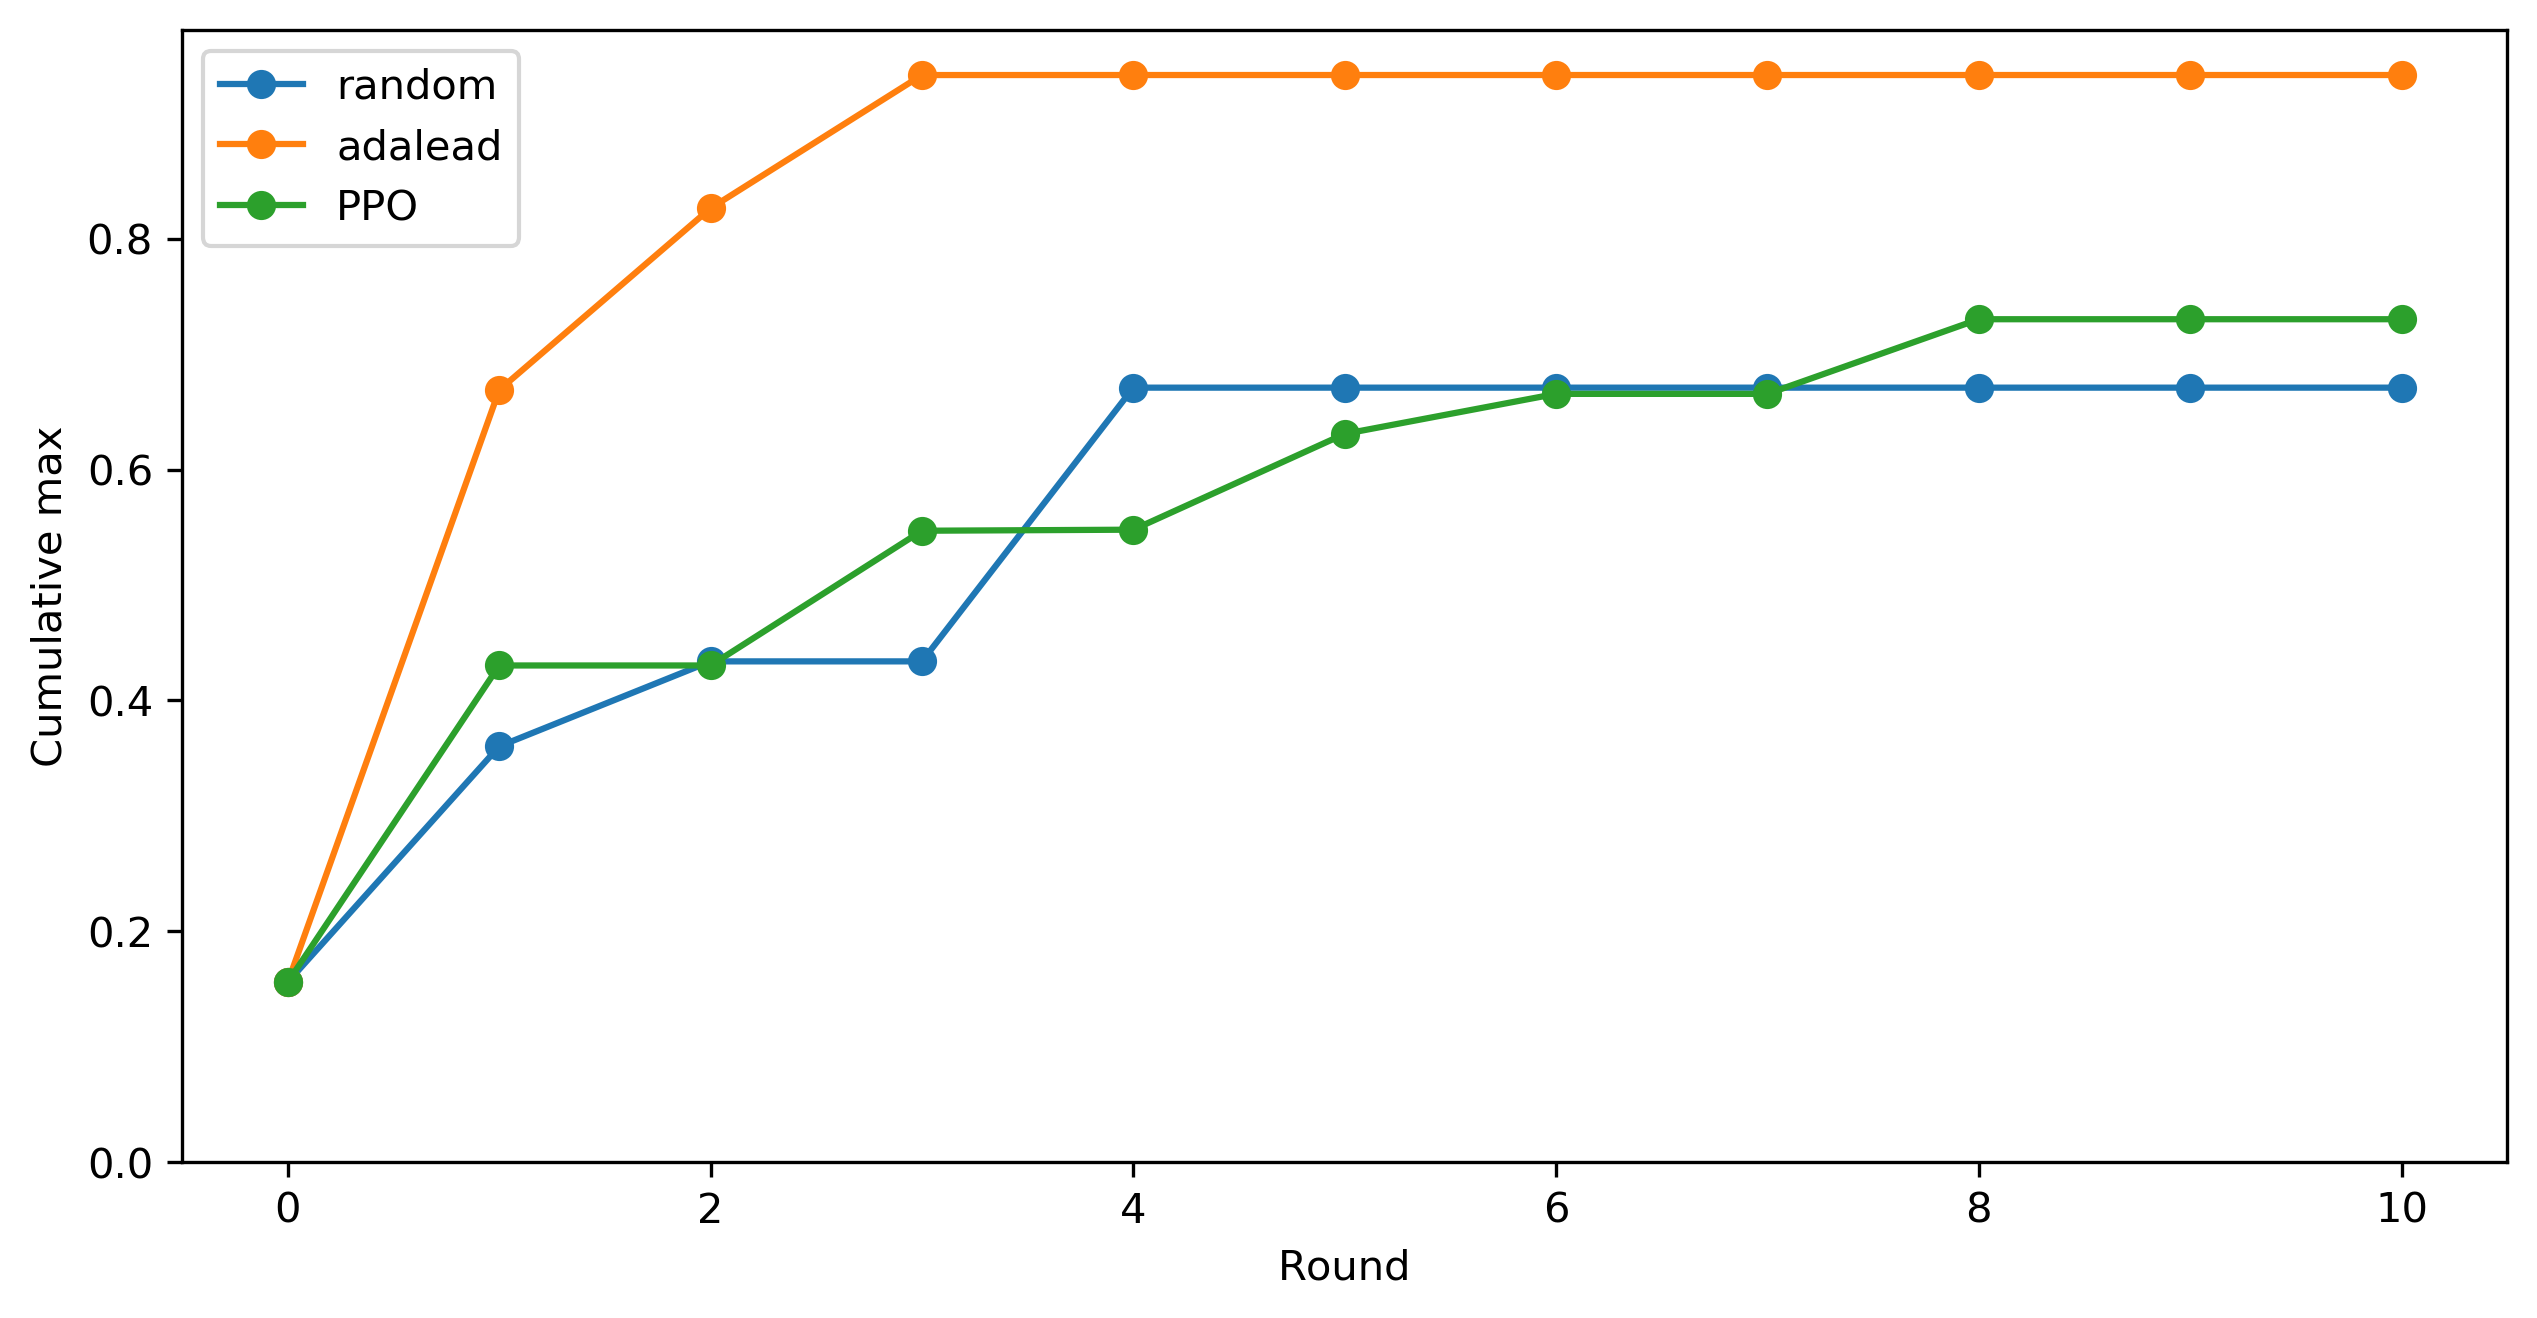

In [63]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)

plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(11), cumulative_max_per_round(random_sequences), 'o-', label="random")
plt.plot(range(11), cumulative_max_per_round(adalead_sequences), 'o-', label="adalead")
plt.plot(range(11), cumulative_max_per_round(ppo_sequences), 'o-', label="PPO")
plt.ylabel("Cumulative max")
plt.xlabel("Round")
plt.legend()
plt.ylim(0)
plt.show()

## 4. Evaluating an exploration algorithm <a class="anchor" id="section-four"></a>


Pick the landscapes you want to run the evaluation suite on. This can be done by including indexes or "all" which results in loading all pre-defined landscapes. 

**WARNING**: Running evaluators on all landscapes would take forever if not done in a parallel fashion. Debug your process with a couple of landscapes first. We recommend sending each evaluation-landscape pair to a separate worker.  

In [ ]:
# This is old! I am still in the middle of rewriting the evaluation suite,
# so I'm leaving this here for reference

greedy_exp= Greedy(recomb_rate=0.2, threshold=0.05, mu=2, virtual_screen=20)
LANDSCAPE_TYPES ={"RNA": [0],"TF": []}#["GFP": "all","ADDITIVE":"all"]
evaluator=Evaluator(greedy_exp,landscape_types=LANDSCAPE_TYPES, path="../simulations/eval/",ML_ensemble=["GB","Linear","CNNa", "CNNa"])\
                                                                    #path to where the results are saved

The evaluator can run tests aimed at different properties of the explorer. 

The tests include:
- `consistency_robustness_independence`: shows how explorer performance changes given different models.
- `efficiency`: shows how explorer performance changes when more computational evals are allowed
- `adaptivity`: shows how the explorer is sensitive to the number of batches it is allowed to sample
- `scalability`: shows how fast the explorer produces a batch. 

Note that once you run a particular test (among these), if you want to run more tests, you need to re-run `load_landscapes` on the evaluator (as the generator stack is depleted.  

In [ ]:
# This is also old!

evaluator.evaluate_for_landscapes(evaluator.consistency_robustness_independence,\
                                  num_starts=2) #num starts determines how many starting points
                                                #should be tested per landscape

In [53]:
def make_explorer(model):
    return baselines.explorers.Random(
            model,
            landscape,
            rounds=5,
            initial_sequences=[wt],
            mu=mutation_rate,
            sequences_batch_size=1000,
            model_queries_per_batch=5000,
            alphabet=s_utils.RNAA
        )

flexs.evaluate.robustness(landscape, make_explorer)

Evaluating for signal_strength: 0
round: 1, top: 0.4229142433446849
round: 2, top: 0.5272697400008672
round: 3, top: 0.5217773261422901
round: 4, top: 0.6590871488113138
round: 5, top: 0.6590871488113138
Evaluating for signal_strength: 0.5
round: 1, top: 0.46410719014539203
round: 2, top: 0.5657164798722858
round: 3, top: 0.6151479950813181
round: 4, top: 0.6371175981360863
round: 5, top: 0.7689350069465327
Evaluating for signal_strength: 0.9
round: 1, top: 0.5657164798722858
round: 2, top: 0.590432237476802
round: 3, top: 0.6865491133451186
round: 4, top: 0.724995853216537
round: 5, top: 0.7716812138758213
Evaluating for signal_strength: 1
round: 1, top: 0.6233866158691839
round: 2, top: 0.6343713912067976
round: 3, top: 0.6728181310782162
round: 4, top: 0.7854121961427237
round: 5, top: 0.757950231608919
